In [12]:
import numpy as np
import pandas as pd
import logging
import seaborn as sns
sns.set(style="darkgrid")

### Logger

In [175]:
#logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

#logging.basicConfig
fh = logging.FileHandler('logger_lineplot.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

'''
#For streaming only
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)
'''

logger.info('This is a test log message.')

## Render graph functions

In [13]:
def renderGraph(db, workload):
    new_db = setCriteria(db, workload)
    graph = setLinePlot(new_db,workload)
    exportGraph(graph, workload)

def setCriteria(db, workload):
    return db[db.workload == workload]

def setLinePlot(db, workload):
    dbgraph = sns.lineplot(x=db.record_nbr, 
                          y=db.value, 
                          hue=db.database,
                          style=db.database,
                          sort=False,
                          legend='full',
                          markers=True,
                          dashes=True)
    handles, labels = dbgraph.get_legend_handles_labels()
    dbgraph.legend(handles=handles[1:], 
                   labels=labels[1:])
    dbgraph.set(xlabel='Number of Records', 
                ylabel="Time (seconds)")
    dbgraph.set_title(workload.upper())
    dbgraph
    
    return dbgraph

def setFileName(workload):
    name = workload.replace(" ", "")
    filename = "".join((name,'.png'))
    return filename

def exportGraph(graph, workload):
    name = setFileName(workload)
    fig = graph.get_figure()
    fig.savefig(name)
    fig.show
    return


In [143]:
class LinePlot():
    
    def __init__(self, db, workload):
        self.db = db
        self.workload = workload

    #TODO refractor x y graph axis
    def graph_ops_vs_latency(self):
        new_db = self.set_criteria(self.db, self.workload)
        graph = self.set_ops_latency(new_db, self.workload)
        self.exportGraph(graph, self.workload)
        return
    
    def graph_records_vs_latency(self):
        new_db = self.set_criteria(self.db, self.workload)
        graph = self.set_records_latency(new_db, self.workload)
        self.exportGraph(graph, self.workload)
        return
    
    @staticmethod
    def set_criteria(db, workload):
        return db[db.workload == workload]
    
    @staticmethod
    def set_ops_latency(db, workload):
        dbgraph = sns.lineplot(x=db.throughput_value, 
                              y=db.runtime_value, 
                              hue=db.database,
                              style=db.database,
                              sort=True,
                              legend='full',
                              markers=True,
                              dashes=True)

        handles, labels = dbgraph.get_legend_handles_labels()
        
        dbgraph.legend(loc=2, 
                       handles=handles[1:], 
                       labels=labels[1:])
        dbgraph.set(xlabel='Throughput(ops/sec)', 
                    ylabel="Read latency(ms)")
                    
        dbgraph.set_title(workload.upper())
        return dbgraph
    
    @staticmethod
    def set_records_latency(db, workload):
        dbgraph = sns.lineplot(x=db.record_nbr, 
                              y=db.runtime_value, 
                              hue=db.database,
                              style=db.database,
                              sort=False,
                              legend='full',
                              markers=True,
                              dashes=True)
        
        handles, labels = dbgraph.get_legend_handles_labels()
        dbgraph.legend(loc=2, 
                       handles=handles[1:], 
                       labels=labels[1:])
        
        dbgraph.set(xlabel='Number of Records', 
                    ylabel="Time (seconds)")
        
        dbgraph.set_title(workload.upper())
        return dbgraph

    @staticmethod
    def setFileName(workload):
        extension = ".png"
        name = workload.replace(" ", "")
        filename = "".join((name,extension))
        return filename

    @staticmethod
    def exportGraph(graph, workload):
        name = setFileName(workload)
        fig = graph.get_figure()
        fig.savefig(name)
        fig.show
        return

## Iterate thru the output folder and get root path

In [213]:
import re

from os import path
from os import walk

class FileIterator:
    
    def __init__(self):
        self.path_root = 'output'

    def iterate_filenames(self):
        databases = self.__iterate_database(self.path_root)
        files = self.__iterate_file(databases)
        return files

    def __iterate_database(self, root_dir):
        path_dbs = []
        databases = ['redis','mongodb','cassandra-cql']
        #databases = ['mongodb']

        for database in databases:
            path_dbs.append(root_dir + '/' + database)
        return path_dbs

    def __iterate_file(self, path_dbs):
        path_db_workload_files = []
        
        for path_db in path_dbs:
            for root, dirs, files in walk(path_db):  
                for filename in files:
                    if ".ipynb_checkpoints" in dirs:
                        pass
                    else: 
                        if ".swp" not in filename and ".DS_Store" not in filename and ".txt~" not in filename:
                            path_db_workload_files.append(root + '/' + filename)
                            #logger.debug(root + '/' + filename)
        return path_db_workload_files

## Set dataframe values

In [61]:
class BuildDataFrame():
    
    def __init__(self, output, filename_path):
        self.output = output
        self.filename_path = filename_path
        self.file = filename_path.split(sep='/')
        self.filename = filename_path.split(sep='/')[len(filename_path.split(sep='/'))-1]
        
    def set_data_row(self):
        
        output_data = {}
        output_data['run'] = self.__set_run(self.filename)
        output_data['database'] = self.__set_database(self.filename_path)
        output_data['workload'] = self.__set_workload(self.filename)
        output_data['record_nbr'] = self.__set_record_nbr(self.filename)
        output_data['records'] = str(self.__set_record_nbr(self.filename))
        output_data['type'] = self.__set_type(self.output)
        #output_data['label'] = self.__set_label(self.output)
        #output_data['value'] = self.__set_value(self.output)
        
        output_data['runtime'] = self.__set_runtime(self.output)
        output_data['runtime_value'] = self.__set_runtime_value(self.output)
        output_data['throughput'] = self.__set_throughput(self.output)
        output_data['throughput_value'] = self.__set_throughput_value(self.output)
        
        return output_data

    def __set_runs(self,file):
        filename = (file[len(file)-1])
        col_run = filename.split(sep='.')[1]
        return col_run
    
    def __set_run(self,filename):
        col_run = filename.split(sep='.')[1]
        return col_run

    def __set_database(self, filename_path):
        database_name = ''
        col_database = filename_path.split(sep='/')[1]

        if(col_database == 'cassandra-cql'):
            database_name = 'Cassandra'
        else:
            database_name = col_database.title()

        return database_name

    def __set_workload(self, filename):
        col_workload = filename.split(sep='.')[2]

        w_type = col_workload[len(col_workload)-1]
        w_base = col_workload[:-1]

        workload_name = w_base + ' ' + w_type

        return workload_name
    
    def __set_record_nbr(self, filename):
        record_nbr = ''
        col_record = filename.split(sep='.')[0]

        if(col_record == '1k'):
            record_nbr = 1000
        elif(col_record == '2k'):
            record_nbr = 2000
        elif(col_record == '3k'):
            record_nbr = 3000
        elif(col_record == '10k'):
            record_nbr = 10000
        elif(col_record == '100k'):
            record_nbr = 100000
        elif(col_record == '1000k'):
            record_nbr = 1000000
        else:
            record_nbr = 100

        return record_nbr
    
    def __set_type(self, output):
        task_type = output.loc[0][0]
        return task_type[1:-1]
    
    
    def __set_label(self, output):
        #runtime
        #task_label = output.loc[0][1].lstrip()
        #throughput
        task_label = output.loc[1][1].lstrip()
        return task_label

    def __set_value(self, output):
        #runtime
        #seconds =  float(output.loc[0][2]) / 1000
        #throughput
        seconds =  float(output.loc[1][2]) 
        return seconds
    
    def __set_runtime(self, output):
        #runtime
        runtime_label = output.loc[0][1].lstrip()
        return runtime_label

    def __set_runtime_value(self, output):
        #runtime
        runtime_value =  float(output.loc[0][2]) 
        return runtime_value
    
    def __set_throughput(self, output):
        throughput_label = output.loc[1][1].lstrip()
        return throughput_label

    def __set_throughput_value(self, output):
        #runtime
        #seconds =  float(output.loc[0][2]) / 1000
        #throughput
        throughput_value =  float(output.loc[1][2])
        return throughput_value

### Read from csv files

In [131]:
class CSVReader():
    
    def __init__(self, filename_paths):
        self.filename_paths = filename_paths
        
    def get_data(self):
        data = []
        for filename_path in self.filename_paths:
            #print(filename_path)
            file = filename_path.split(sep='/')
            filename = (file[len(file)-1])
            database = file[1]

            if(database == 'mongodb'):
                csv_output = pd.read_csv(filename_path, skiprows=1, header=None)
            else:
                csv_output = pd.read_csv(filename_path, header=None)

            #TODO refractor 
            df_output = BuildDataFrame(csv_output, filename_path)
            data.append(df_output.set_data_row())

        return data

## __Main__

In [214]:
files = FileIterator()
file_paths = files.iterate_filenames()
#print(file_paths)
csv_files = CSVReader(file_paths)

csv_data = []
csv_data = csv_files.get_data()

### Convert source file to dataFrame

In [228]:
data_df = pd.DataFrame(csv_data, columns=['run','database','workload','record_nbr','records','type','throughput','throughput_value','runtime','runtime_value'])
data_df.head(2)

,run,database,workload,record_nbr,records,type,throughput,throughput_value,runtime,runtime_value
0,run-1,Redis,workload a,1000,1000,OVERALL,Throughput(ops/sec),971.817298,RunTime(ms),1029.0
1,run-2,Redis,workload a,1000,1000,OVERALL,Throughput(ops/sec),669.792364,RunTime(ms),1493.0


### Export to CSV

In [226]:
data_df.to_csv('output_df.csv',sep=',')

### Read from CSV

In [229]:
zero_df = pd.read_csv("zero_df.csv")
zero_df['records'].astype('str')
zero_df['records'] = zero_df['records'].apply(str)
zero_df.head(2)

,run,database,workload,record_nbr,records,type,throughput,throughput_value,runtime,runtime_value
0,run-1,Redis,workload a,0,0,OVERALL,Throughput(ops/sec),0.0,RunTime(ms),0.0
1,run-2,Redis,workload a,0,0,OVERALL,Throughput(ops/sec),0.0,RunTime(ms),0.0


### Add Zero based pointer

In [230]:
db3 = pd.concat([zero_df,data_df], ignore_index=True)

In [164]:
db3.to_csv('concat_df.csv',sep=',')

### Render Graphs

## WORKLOAD INSERT

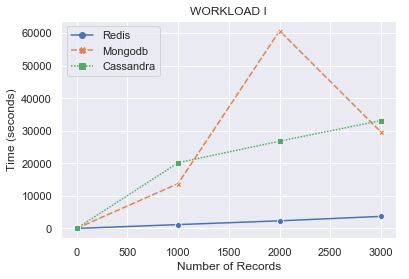

In [217]:
workload = 'workload i'
load_1 = db3.query("run=='load-1'")
graph_i = LinePlot(load_1,workload)
graph_i.graph_records_vs_latency()

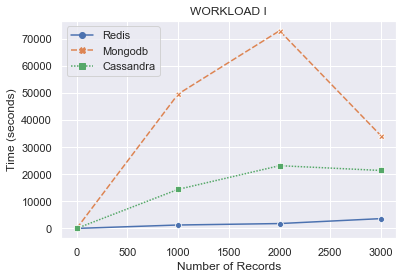

In [218]:
workload = 'workload i'
load_2 = db3.query("run=='load-2'")
graph_i = LinePlot(load_2,workload)
graph_i.graph_records_vs_latency()

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


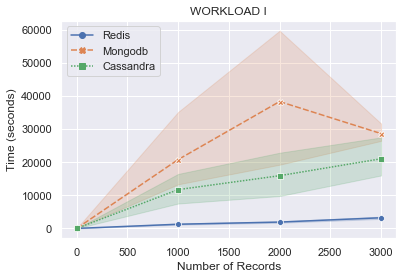

In [231]:
workload = 'workload i'
graph_i = LinePlot(db3,workload)
graph_i.graph_records_vs_latency()

,run,database,workload,record_nbr,records,type,throughput,throughput_value,runtime,runtime_value
31,load-2,Redis,workload i,1000,1000,OVERALL,Throughput(ops/sec),792.393027,RunTime(ms),1262.0
33,load-2,Redis,workload i,2000,2000,OVERALL,Throughput(ops/sec),1114.206128,RunTime(ms),1795.0
35,load-2,Redis,workload i,3000,3000,OVERALL,Throughput(ops/sec),828.729282,RunTime(ms),3620.0


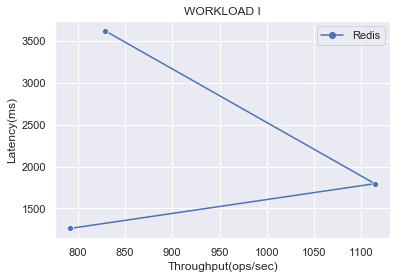

In [203]:

def chart_ops_latency(db, workload):
    dbgraph = sns.lineplot(x=db.throughput_value, 
                            y=db.runtime_value, 
                            hue=db.database,
                            style=db.database,
                            sort=False,
                            legend='full',
                            markers=True,
                            dashes=True)

    handles, labels = dbgraph.get_legend_handles_labels()
    dbgraph.legend(handles=handles[1:], 
                   labels=labels[1:])
    
    dbgraph.set(xlabel='Throughput(ops/sec)', 
                ylabel="Latency(ms)")
    
    dbgraph.set_title(workload.upper())
    return dbgraph
    
workload = 'workload i'
db5 = db3[db3.workload == workload]
db5 = db5.sort_values(by=['record_nbr'])
db5 = db5.query("run=='load-2'")
db5 = db5.query("database=='Redis'")
chart_ops_latency(db5,workload)

db5

## WORKLOAD A

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


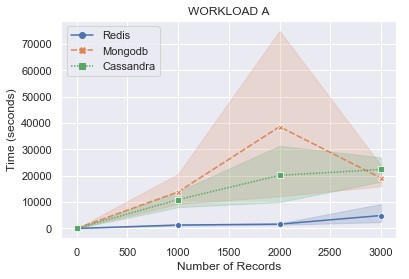

In [232]:
workload = 'workload a'
graph_a = LinePlot(db3,workload)
graph_a.graph_records_vs_latency()

## WORKLOAD B

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


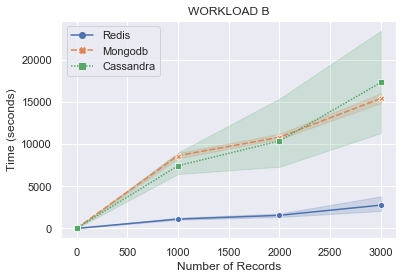

In [233]:
workload = 'workload b'
graph_b = LinePlot(db3,workload)
graph_b.graph_records_vs_latency()

## WORKLOAD C

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


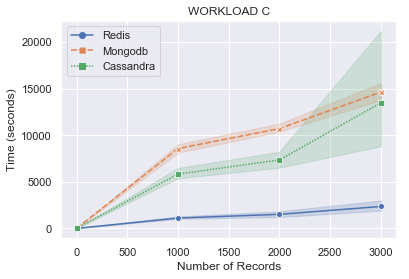

In [234]:
workload = 'workload c'
graph_c = LinePlot(db3,workload)
graph_c.graph_records_vs_latency()

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


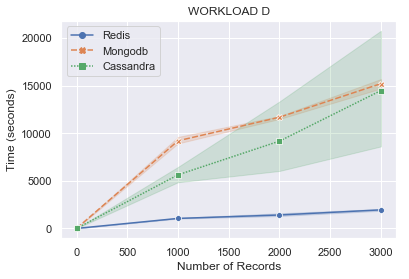

In [236]:
workload = 'workload d'
graph_d = LinePlot(db3,workload)
graph_d.graph_records_vs_latency()

/Users/ghost/src/virtual_env/jupyther3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


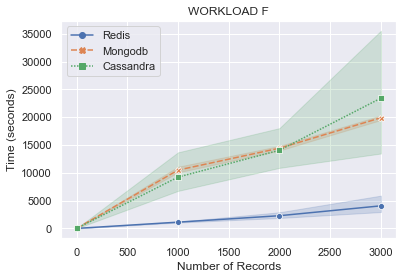

In [237]:
workload = 'workload f'
graph_f = LinePlot(db3,workload)
graph_f.graph_records_vs_latency()